# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

# Note: Adjust the data to have center at the origin first!
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1,1))
data_scaled = scaler.fit_transform(data)

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer: Some ideas about latent variables:
#### For PCA:
* Necessary goods: fresh, milk, grocery, frozen, detergents_paper
* Quickly perishable: fresh, milk, grocery, delicatessen
* Slowly or non-perishable: frozen, detergents, paper

#### For ICA: 
* Necessary goods vs luxury goods
* Perishable vs non-perishable

### PCA

In [15]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data_scaled)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.018545    0.49047312  0.57644674 -0.01741587  0.647882    0.08213992]
 [-0.86387717 -0.18182434  0.00363933 -0.39690977  0.12652721 -0.21701704]
 [ 0.50178356 -0.33371506  0.08680857 -0.65833746  0.22070584 -0.38365676]
 [-0.02403365 -0.62796031  0.19740892  0.60521878  0.35050483 -0.27744285]
 [-0.00662714 -0.46794556  0.20894177 -0.20580297  0.05718506  0.83168587]
 [-0.03104894 -0.0412685   0.75995608 -0.01031851 -0.6240232  -0.17403508]]
[ 0.51948323  0.26407007  0.106061    0.06258016  0.03497422  0.01283132]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: The variance drops off really quickly after the second component. If I were to use PCA on this dataset, I would choose at least 2 and at most 4 components. The exact number will be decided after trying each value (Grid Search) with F1 score.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

* First component: Fresh produce seems to dominate this component. This makes sense because Fresh produce data has the highest standard deviation, almost 40% more than the second highest (grocery). 

* Second component: Strong correlation between Milk, Grocery and Detergents_Paper, explaining almost the other half of the variances. 

### ICA

[[ 0.00884603  0.36125403 -0.26960453 -0.01121293  0.06833643 -0.14419466]
 [ 0.2230092  -0.0322613  -0.03197769 -0.0204306   0.04506221 -0.02394189]
 [-0.01153488  0.06726362 -0.316416   -0.01093082  0.03502706  0.03910392]
 [-0.02173246 -0.00880019 -0.02714317 -0.01605355  0.01019859  0.43403483]
 [-0.0160272   0.08715376  0.54910789 -0.04489054 -0.57462686 -0.13657233]
 [-0.04848214 -0.00504698  0.03572173  0.33909    -0.01111662 -0.14246657]]


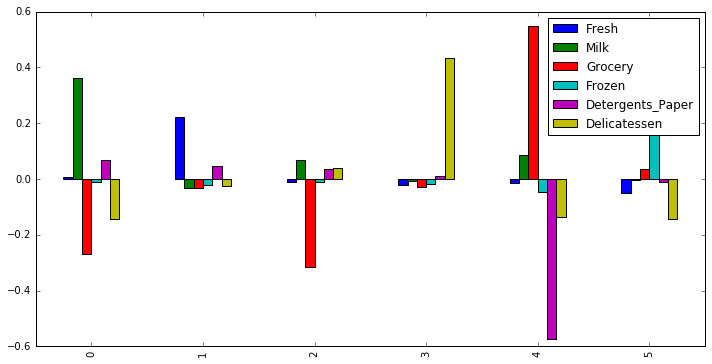

In [16]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
# => This step has been done earlier with MinMaxScaler
from sklearn.decomposition import FastICA
ica = FastICA(n_components = data.shape[1], random_state=918)
ica.fit(data_scaled)

# Print the independent components
print ica.components_

# Visualize ICA result
pd.DataFrame(ica.components_, columns=data.columns).plot(kind = 'bar', figsize = (12, 6))

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Below are the vectors and its strong correspondences (Please note that the order of the vectors does not matter; they are linearly independent; The order of the vectors below might be different from what you'll see when printing `ica.components_`)

* Vector 0: Delicatessen
* Vector 1: Frozen and Delicatessen, negative correlation, frozen dominates. The underlying variable could be "speed of perishing"
* Vector 2: Milk(+), Grocery(-) and Delicatessen(-). The underlying variable could be "convenient edibles"
* Vector 3: Grocery
* Vector 4: Grocery and Detergents_Paper, negative correlation. The underlying variable could be "budget": these items are substitutes under a tight budget 
* Vector 5: Fresh

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: The advantage of K Means clustering model includes scalability and richness (it's a great general purpose algorithm)

I haven't learned Gaussian Mixture Model in the course

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [4]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [5]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca2d = PCA(n_components=2)
reduced_data = pca2d.fit_transform(data_scaled)
print reduced_data[:10]  # print upto 10 elements

[[ 0.0408917   0.00824865]
 [ 0.09000658  0.07377718]
 [ 0.08094827  0.02749195]
 [-0.18458917 -0.05757255]
 [-0.04102739 -0.21266026]
 [-0.03472033  0.05276793]
 [-0.04053275  0.05513731]
 [ 0.02688573  0.08399289]
 [-0.08669149  0.13783465]
 [ 0.35581798  0.11491167]]


In [6]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

clusters2c = KMeans(n_clusters=2)
clusters3c = KMeans(n_clusters=3)
clusters2c.fit(reduced_data)
clusters3c.fit(reduced_data)
print clusters2c
print clusters3c

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [7]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z2 = clusters2c.predict(np.c_[xx.ravel(), yy.ravel()])
Z3 = clusters3c.predict(np.c_[xx.ravel(), yy.ravel()])

In [8]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids2c = clusters2c.cluster_centers_
centroids3c = clusters3c.cluster_centers_
#centroids = clusters.means_
print centroids2c
print centroids3c

[[  7.63793167e-01  -3.40715273e-03]
 [ -9.13442210e-02   4.07471191e-04]]
[[-0.15007641 -0.02732374]
 [ 1.4270389  -0.34221452]
 [ 0.29018749  0.12035043]]


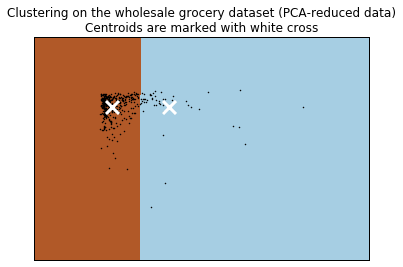

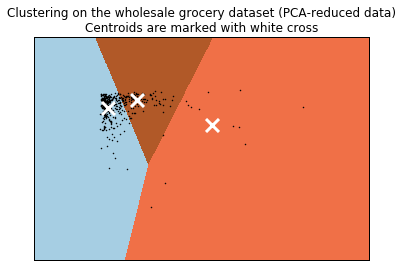

In [9]:
# Put the result into a color plot
Z2 = Z2.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z2, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids2c[:, 0], centroids2c[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# Another plot for 3 clusters
Z3 = Z3.reshape(xx.shape)
plt.figure(2)
plt.clf()
plt.imshow(Z3, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids3c[:, 0], centroids3c[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [11]:
# Obtain original customer information
centroids_before_pca = pca2d.inverse_transform(centroids2c)
print centroids_before_pca
centroids_before_scale = scaler.inverse_transform(centroids_before_pca)
print centroids_before_scale

[[-0.79726645 -0.46841431 -0.38838478 -0.91179425 -0.3645636  -0.87303205]
 [-0.78470329 -0.8885298  -0.88131205 -0.89841535 -0.91810907 -0.9441008 ]]
[[ 11371.08090754  19575.62407045  28374.91283508   2708.39529232
   12973.52775015   3046.42173856]
 [ 12075.54757594   4148.35284654   5508.75597138   3115.40819659
    1674.55774998   1342.90376155]]


**7)** What are the central objects in each cluster? Describe them as customers.

Answer: After doing a PCA inverse transform on two centroids, I can deduce the following

* The first centroid (customer) spent most amount of money on Fresh products
* The second centroid (customer) spent significantly more on milk, grocery and detergents_paper

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: PCA gave me the most insight to the data. It is interesting to see that there is correlation between products, and that they can be split into 2 groups: Fresh and (Milk, Grocery, Detergents_Paper). 

Interestingly, KMeans result also concurs with PCA analysis result. 

**9)** How would you use that technique to help the company design new experiments?

Answer: To be honest, I would choose to use a different learning technique, because there seems to be only one cluster, unless I messed up somewhere else.

However, if I have to use this result, I will recommend the company to separate customers into 2 groups: those who spend more than half of their budget on Fresh products, and those who spend more than half of their budgets on (Milk, Grocery and Detergents_Paper) products. 

**10)** How would you use that data to help you predict future customer needs?

Answer: I would say, I can't predict anything. Is this a trick question? I thought the purpose of this unsupervised learning project is to separate existing customers based on their spending patterns, so that the company can carry out better experiment. 